In [1]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import shutil
import glob
from scipy import ndimage
from scipy import signal
import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings
import csv
import tensorflow as tf


In [90]:
# RUN Utility functions

# One time init
# with open('results.csv', 'w') as csvfile:
#     csvout = csv.writer(csvfile)
#     csvout.writerow(["File", "Model", "Gap", "Slice_size", "Count", "Precision", "Recall", "F-score", "True Count", "Error Rate"])

#BASIC CROP FRAME
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.92
CUBE_SIZE = 250

# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

# returns a logical matrix of values beyond a threshld
def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val

def calc_min_max_coordinates(image, crop_val=50):
    temp = thresholded(image, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

def calc_min_max_coordinates_dynamic(image, cutoff=1):
    temp = exposure.equalize_adapthist(image, clip_limit=0.03)
    flat = np.sort(np.matrix.getA1(temp))
    sum_all = np.sum(flat)
    index = np.argmin(flat.cumsum() < (sum_all * cutoff))

    temp = thresholded(temp, flat[index])
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    return ymin, ymax, xmin, xmax

# initial static crop and a seondary dynamic crop based on signal2noise ratio
def crop_full_scan(image):
    temp = crop(image, Y_START, Y_END, X_START, X_END)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(temp, cutoff=BG_2_OBJ_RATIO)
    temp = crop(image, Y_START+ymin, Y_START+ymax, X_START+xmin, X_START+xmax)
    return temp

def crop_thresholded(image):
    temp = crop(image, 0, image.shape[0]-1, 0, image.shape[1]-1)
    ymin, ymax, xmin, xmax = calc_min_max_coordinates(temp)
    temp = crop(image, ymin, ymax, xmin, xmax)
    return temp

def read_and_crop(image_name):
    if "il239838" in os.getcwd():
        image = img.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/" + image_name)
    else:
        f = urllib.request.urlopen("https://dl.dropboxusercontent.com/s/31b96942qdcn73k/" + image_name)
        image = img.imread(f, format='jpeg')

    # Smart-crop the image to get rid of all the noise and redundant area
    # return crop_full_scan(image)
    cropped = crop_full_scan(image)
    return exposure.equalize_adapthist(cropped, clip_limit=0.03)


# TODO: fix performance!!! http://scikit-image.org/docs/dev/user_guide/tutorial_parallelization.html
def combine_3_images_to_RGB(red, green, blue):
    new_image = np.empty((blue.shape[0],blue.shape[1],3))
    for x in range(0, blue.shape[0]):
        for y in range(0, blue.shape[1]):
            new_image[x,y,0] = red[x,y]
            new_image[x,y,1] = green[x,y]
            new_image[x,y,2] = blue[x,y]
    return new_image

def slice_image_left_edge(original, width=200, rotate=0):
    rot = ndimage.rotate(original, rotate)
    # Slice the left slice of the so-called "blue" image
    left_edge_orig = crop(rot, 1, 1400, 1, width)
    left_edge_orig = crop_thresholded(left_edge_orig)

    # Copy to a new array so we don't thrash the origin
    left_edge = np.empty_like (left_edge_orig)
    np.copyto(left_edge, left_edge_orig)

    # Zero down low level "noise" values
    low_values_indices = left_edge < 30  # Where values are low
    left_edge[low_values_indices] = 0  # All low values set to 0
    return left_edge

def get_best_angle_rotation(original, crop=True, width=200):
    min_var = 99999999999
    best_angle = -10
    for x in range(-5,5):
        if crop:            
            rot_edge = slice_image_left_edge(original, width, x)
        else:
            rot_edge = ndimage.rotate(original, x)
        left_var = np.var(rot_edge, axis=1)
        # left_var = np.apply_along_axis(lambda v: np.var(v[np.nonzero(v)]), 1, rot_edge)
        var_sum = np.sum(left_var)
        if (var_sum < min_var):
            min_var = var_sum
            best_angle = x
    print ("best_angle="+str(best_angle))
    return best_angle

#     import pdb; pdb.set_trace()
def calc_neighbors(slice_map, col, row):
    # import pdb; pdb.set_trace()
    if ((col-1, row) in slice_map and slice_map[(col-1, row)] != None):
        slice_map[(col, row)]["left"] = slice_map[(col-1, row)]
        slice_map[(col-1, row)]["right"] = slice_map[(col, row)]
    if ((col+1, row) in slice_map and slice_map[(col+1, row)] != None):
        slice_map[(col, row)]["right"] = slice_map[(col+1, row)]
        slice_map[(col+1, row)]["left"] = slice_map[(col, row)]
    if ((col, row-1) in slice_map and slice_map[(col, row-1)] != None):
        slice_map[(col, row)]["top"] = slice_map[(col, row-1)]
        slice_map[(col, row-1)]["bottom"] = slice_map[(col, row)]
    if ((col, row+1) in slice_map and slice_map[(col, row+1)] != None):
        slice_map[(col, row)]["bottom"] = slice_map[(col, row+1)]
        slice_map[(col, row+1)]["top"] = slice_map[(col, row)]
    


def VAL_create_cube(name, raw, x, y):
    cube = {}
    cube["cube"] = raw
    cube["file"] = name
    if name.find('P') == 0:
        cube["index"] = int(name[name.find('P')+1:name.find('P')+4]) * 1000 + int(name[name.find('Fg')+2:name.find('Fg')+5])
    else:
        print("Found a ZERO index cube with the name:"+name)
        cube["index"] = 0
    cube["top_row"] = x
    cube["left_col"] = y
    cube["right_col"] = y + CUBE_SIZE
    return cube
    

ZERO_CUBE = VAL_create_cube("ZERO", np.zeros((CUBE_SIZE, CUBE_SIZE), dtype=np.int), -1, -2)

# slice an image to cubes with 250X250 pixel size
def VAL_slice_to_static_slices(name, cropped_original):
    structure = []
    # cropped_original = cropped_original / 256 # divide by 256 to "normalize" between 0 and 1

    # import pdb; pdb.set_trace()
    x, y = cropped_original["cut"].shape
    print (x,y)
    n = 0
    # every 250 pixels on the x axis == rows
    while ((n + 1) * CUBE_SIZE < x):
        m = 0
        # every 250 pixels on the y axis == cols
        while ((m + 1) * CUBE_SIZE < y):
            if ((m == 0) or ((m + 2) * CUBE_SIZE >= y)): # Only keep the left and right edges of the piece for matching!!
                # cut a cube of 250X250
                cube = crop(cropped_original["cut"], n * CUBE_SIZE, (n + 1) * CUBE_SIZE, m * CUBE_SIZE, (m + 1) * CUBE_SIZE)
                # keep only cubes for which half of the pixels have some "color"
                # print(np.median(cube))
                if np.median(cube) > 0.2: # aligned with the normalization 0.2 correlates to 50
                    # keep the cube
                    new_cube = VAL_create_cube(name, cube, n * CUBE_SIZE, m * CUBE_SIZE)
                    new_cube["col"] = m
                    new_cube["row"] = n
                    new_cube["orig"] = cropped_original
                    new_cube["col_px_left"] = cropped_original["col_px"] + m * CUBE_SIZE
                    new_cube["col_px_right"] = cropped_original["col_px"] + (m + 1) * CUBE_SIZE
                    new_cube["row_px_top"] = cropped_original["row_px"] + n * CUBE_SIZE
                    new_cube["row_px_bottom"] = cropped_original["row_px"] + (n + 1) * CUBE_SIZE
                    structure.append(new_cube)
            m += 1
        n += 1
            
    # return the data structure with all the cubes and the counters of the rows and columns
    return structure

def pad_above(original, above, amount):
    res = np.insert(original["cube"], np.zeros(amount), above["cube"][-amount:], axis=0)
    res = np.delete(res, np.arange(CUBE_SIZE,CUBE_SIZE+amount), axis=0)
    return create_cube(res, original["top_row"] - amount, original["left_col"])
  

def pad_below(original, below, amount):
    res = np.insert(original["cube"], np.full(amount, CUBE_SIZE), below["cube"][:amount], axis=0)
    res = np.delete(res, np.arange(0, amount), axis=0)
    return create_cube(res, original["top_row"] + amount, original["left_col"])

def pad_left(original, left, amount):
    res = np.insert(original["cube"], np.zeros(amount, dtype=int), left["cube"][:,-amount:], axis=1)
    res = np.delete(res, np.arange(CUBE_SIZE, CUBE_SIZE+amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] - amount)

def pad_right(original, right, amount):
    res = np.insert(original["cube"], [CUBE_SIZE], right["cube"][:,:amount], axis=1)
    res = np.delete(res, np.arange(0, amount), axis=1)
    return create_cube(res, original["top_row"], original["left_col"] + amount)
    

# "Shave" the right edge of the cube with <gap> pixels and pad with zeros on the left
def shave_right(original, amount):
    return pad_left(original, ZERO_CUBE, amount)
    

# "Shave" the left edge of the cube with <gap> pixels and pad with zeros on the right    
def shave_left(original, amount):
    return pad_right(original, ZERO_CUBE, amount)
    

# concatenate cubes 
def VAL_concatenate_cubes(left, right, slice_size):
    right_img = right["cube"]
    # if the left cube is matched to another left cube (or right cube to another right cube) then rotate the right
    # cube by 180 so we try to match it upside down, covering the option that the cube was pictured rotated
    if ((left["col"] == 0 and right["col"] == 0) or (left["col"] != 0 and right["col"] != 0)):
        right_img = np.rot90(right["cube"], 2);
    con = np.concatenate((left["cube"][:,-slice_size:], right_img[:,:slice_size]), axis=1)
    x_delta = right["top_row"] - left["top_row"]
    y_delta = right["left_col"] - left["right_col"] 
    return con, x_delta, y_delta, left["file"], right["file"]
    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cube with zeros
def concatenate_cubes_zero_pad_gaps(left_orig, right_orig, gap):
    left = left_orig if gap == 0 else shave_right(left_orig, gap)
    right = right_orig if gap == 0 else shave_left(right_orig, gap)
    return concatenate_cubes(left, right)    

# concatenate cubes while artificially creating a gap between them. Pad the other end of the cobe with the nearby
# continuation of the cubes
def concatenate_cubes_with_gap(left_orig, right_orig, gap, left_pad, right_pad, slice_size):
    # import pdb; pdb.set_trace()
    left = left_orig if gap == 0 else pad_left(left_orig, left_pad, gap)
    right = right_orig if gap == 0 else pad_right(right_orig, right_pad, gap)
    return concatenate_cubes(left, right, slice_size)        

# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def VAL_build_train_set(cubes, slice_size, folder, curr):
    # import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_x_delta = []
    train_y_delta = []
    train_x_file = []
    train_y_file = []
    # iterate over the others (effectively n^2)
    for adj in cubes:
        if (adj["file"] != curr["file"]) and curr["index"] < adj["index"]: # no need to test against self and avoid checking from both directions
            # import pdb; pdb.set_trace()
            # append the adjacent image to the current image
            conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr, adj, slice_size)
            output = folder+x_file[:x_file.rfind(' ')]+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file[:y_file.rfind(' ')]+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
            np.save(output, conc)
            train_imgs.append(output)
            train_x_delta.append(x_delta)
            train_y_delta.append(y_delta)
            train_x_file.append(x_file)
            train_y_file.append(y_file)

    warnings.filterwarnings("default")
    return train_imgs,train_x_delta, train_y_delta, train_x_file, train_y_file


# convert the data structure of cubes into a train set of 2 arrays of images and labels
# each image is a concatanation of 2 images from the original cubes set, covering all combinations of images
# effectively creating Nx(N-1) images
def NEW_build_train_set(cubes, gap):
    # import pdb; pdb.set_trace()
    warnings.filterwarnings("ignore")

    train_imgs = []
    train_lbls = []
    train_x_delta = []
    train_y_delta = []
    # iterate over the rows and cols, essentially going over the grid of sliced cubes
    for row in range(0, rows):
        for col in range(0, cols):
            # if this cube exists (could have been removed previously due to lack of data)
            if (cubes[(col, row)] != None):
                # for each "current" image in the iteration
                curr = cubes[(col, row)]
                # iterate over all the cubes to find all the "other" (adjacent) cubes
                for adj_row in range(0, rows):
                    for adj_col in range(0, cols):
                        if (adj_row != row or adj_col != col):
                            if (cubes[(adj_col, adj_row)] != None):
                                adj = cubes[(adj_col, adj_row)]
                                # append the adjacent image to the current image
                                # pass the filling cubes on the right and left to pad against the gap
                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                    if (gap == 0):
                                        conc, x_delta, y_delta = concatenate_cubes(curr, adj, slice_size)
                                    else:
                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr, adj, gap, curr["left"], adj["right"], slice_size)
                                    train_imgs.append(conc)
                                    train_x_delta.append(x_delta)
                                    train_y_delta.append(y_delta)
                                    # if the adj image is on the same row and on the right of the curr image - it will be marked as match    
                                    if (adj_row == row and adj_col == (col + 1)):
                                        # mark the image as matched
                                        train_lbls.append([0,1])
                                        # need to enrich the set with a few more tru positive samples - so we offset 
                                        # the matched images up ad down a few times and create more matches
                                        if ("top" in curr.keys() and "top"in adj.keys()):
                                            for i in range(5, 101, 5):
                                                curr1 = pad_above(curr, curr["top"],i)
                                                adj1 = pad_above(adj, adj["top"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys() and "top" in curr["left"].keys() and "top"in curr["right"].keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_above(curr["left"], curr["left"]["top"], i) # FIXIT?
                                                        adj1Right = pad_above(adj["right"], curr["right"]["top"], i) # FIXIT?
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("bottom" in curr.keys() and "bottom"in adj.keys()):
                                            for i in range(5, 101, 5):
                                                curr1 = pad_below(curr, curr["bottom"],i)
                                                adj1 = pad_below(adj, adj["bottom"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys() and "bottom" in curr["left"].keys() and "bottom"in curr["right"].keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_below(curr["left"], curr["left"]["bottom"], i) # FIXIT?
                                                        adj1Right = pad_below(adj["right"], curr["right"]["bottom"], i) # FIXIT?
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("left" in curr.keys()): # enough to check only the curr as the left of the adj is the curr
                                            for i in range(5, 101, 5):
                                                curr1 = pad_left(curr, curr["left"],i)
                                                adj1 = pad_left(adj, adj["left"],i) # essentially the curr
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_left(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        adj1Right = pad_left(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                        if ("right" in adj.keys()): # enough to check only the adj as the right of the curr is the adj
                                            for i in range(5, 101, 5):
                                                curr1 = pad_right(curr, curr["right"],i) # essentially the adj
                                                adj1 = pad_right(adj, adj["right"],i)
                                                if (gap == 0 or ("left" in curr.keys() and "right" in adj.keys())):
                                                    if (gap == 0):
                                                        conc, x_delta, y_delta = concatenate_cubes(curr1, adj1, slice_size)
                                                    else:
                                                        curr1Left = pad_right(curr["left"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        adj1Right = pad_right(adj["right"], ZERO_CUBE, i) # FIXIT? + assuming the gap will not be more than 150
                                                        conc, x_delta, y_delta = concatenate_cubes_with_gap(curr1, adj1, gap, curr1Left, adj1Right, slice_size)
                                                    train_imgs.append(conc)
                                                    train_x_delta.append(x_delta)
                                                    train_y_delta.append(y_delta)
                                                    # mark the image as matched
                                                    train_lbls.append([0,1])
                                    else:
                                        # mark the image as not matched
                                        train_lbls.append([1,0])
                                
    warnings.filterwarnings("default")
    return train_imgs, train_lbls, train_x_delta, train_y_delta


def NEW_build_train_set(cubes, gap, slice_size):
    print("#####################################################################")
    print("TRAINING")
    print("#####################################################################")

    train_imgs = []
    train_lbls = []
    train_x_delta = []
    train_y_delta = []

    # iterate over the cubes
    for curr in cubes:
        # iterate over the others (effectively n^2)
        for adj in cubes:
            if (adj["file"] != curr["file"]) and curr["index"] < adj["index"]: # no need to test against self and avoid checking from both directions
                # import pdb; pdb.set_trace()
                # append the adjacent image to the current image
                conc, x_delta, y_delta, x_file, y_file = VAL_concatenate_cubes(curr, adj, slice_size)
                output = folder+x_file[:x_file.rfind(' ')]+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])+"---"+y_file[:y_file.rfind(' ')]+"_"+str(adj["top_row"])+"_"+str(adj["left_col"])
                np.save(output, conc)
                train_imgs.append(output)
                train_x_delta.append(x_delta)
                train_y_delta.append(y_delta)

    warnings.filterwarnings("default")
    return train_imgs, train_lbls, train_x_delta, train_y_delta
        
    print("#####################################################################")
    print("VALIDATION ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")


def frame_to_n_by_m(orig, start_vector, end_vector, is_col):
    max_val = np.amax(end_vector)
    min_val = np.amin(start_vector)
    width = max_val - min_val
    if (is_col):
        result = np.zeros((start_vector.size, width))
    else:
        result = np.zeros((width, start_vector.size))
    
    for i in range(0, start_vector.size):
        if (is_col):
            row_vec = orig[i, start_vector[i]:end_vector[i]]
        else:
            row_vec = orig[start_vector[i]:end_vector[i],i]
        temp = np.lib.pad(row_vec, (start_vector[i]-min_val, max_val-end_vector[i]), 'constant', constant_values=(0.09, 0.09))
        if (is_col):
            if (result[i].size != width):
                import pdb; pdb.set_trace()
            result[i] = temp[0:width]
        else:
            result[:,i] = temp[0:width]
    return min_val, result

def rough_tear_line(orig, start_vector, cut_mean, is_col, chew_factor):
    end_vector = np.empty(start_vector.size).astype(int)
    if (is_col and np.absolute(cut_mean-orig.shape[1]) < 10):
        end_vector.fill(orig.shape[1])
    elif (not is_col and np.absolute(cut_mean-orig.shape[0]) < 10):
        end_vector.fill(orig.shape[0])
    else:
        deviation_vector = np.random.normal(0, chew_factor, start_vector.size).astype(int)
        end_vector[0] = cut_mean + deviation_vector[0]
        for i in range(1, end_vector.size):
            end_vector[i] = end_vector[i - 1] + deviation_vector[i]
    
    start_px, cut_piece = frame_to_n_by_m(orig, start_vector, end_vector, is_col)    
    return start_px, cut_piece, end_vector

def rough_tear_image(image, cols, rows):
    pieces = []
    col_width = int(image.shape[1] / cols)
    row_height = int(image.shape[0] / rows)
    print(col_width, row_height)
    next_col_start_vec = np.zeros((image.shape[0],), dtype=int)
    for col_idx in range(0, cols):
    #         import pdb; pdb.set_trace()
        start_col_px, cut_column, next_col_start_vec =  rough_tear_line(image, next_col_start_vec, col_width * (col_idx + 1), True, 5)
        next_row_start_vec = np.zeros((cut_column.shape[1],), dtype=int)
        for row_idx in range(0, rows):
            start_row_px, cut_piece, next_row_start_vec = rough_tear_line(cut_column, next_row_start_vec, row_height * (row_idx + 1), False, 1)

            ymin, ymax, xmin, xmax = calc_min_max_coordinates_dynamic(cut_piece, cutoff=BG_2_OBJ_RATIO)
            temp = crop(cut_piece, ymin, ymax, xmin, xmax)
            
            #import pdb; pdb.set_trace()
            piece = {}
            piece["orig"] = cut_piece
            piece["cut"] = temp
            piece["col"] = col_idx
            piece["row"] = row_idx
            piece["col_px"] = start_col_px + xmin
            piece["row_px"] = start_row_px + ymin
            pieces.append(piece)
            
    return pieces

Found a ZERO index cube with the name:ZERO


In [3]:
# RUN Define model util functions

# initialize a shaped matrix of weights with random values
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# initialize a shaped matrix of bias with random values
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

def max_pool_2x1(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 1, 1],
                        strides=[1, 2, 1, 1], padding='SAME')

def max_pool_1x1(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],
                        strides=[1, 1, 1, 1], padding='SAME')

def max_pool_5x5(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 5, 1],
                        strides=[1, 5, 5, 1], padding='SAME')

def max_pool_5x2(x):
  return tf.nn.max_pool(x, ksize=[1, 5, 2, 1],
                        strides=[1, 5, 2, 1], padding='SAME')


In [4]:
# RUN Image utility functions (external source)
def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8
    return ep

def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    


In [5]:
# RUN Define the model - 250, 125, 62, 25
def model_tf(input_width): 
    global accuracy, correct_prediction, train_step, x, y_, y_conv, keep_prob
    
    # foundation of the model - the input layer of the image 250 x input_width*2
    x = tf.placeholder(tf.float32, [None, 250, input_width*2])
    x_image = tf.reshape(x, [-1,250,input_width*2,1]) # 1 is the number of color channels

    # the target digits of the model
    y_ = tf.placeholder(tf.float32, [None, 2])

    # first convolutional layer: one input image and 32 output filters of 5x5
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    if (input_width == 250):
        h_pool1 = max_pool_2x2(h_conv1) # size is reduced to 125x250
    elif (input_width == 125):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x250
    elif (input_width == 62):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool1 = max_pool_2x1(h_conv1) # size is reduced to 125x50
    else:
        print("ERROR - unsupported slice width")
        return

    # second convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv2 = weight_variable([5, 5, 32, 32])
    b_conv2 = bias_variable([32])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    if (input_width == 62):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x125
    elif (input_width == 25):
        h_pool2 = max_pool_1x1(h_conv2) # size is reduced to 125x50
    else:
        h_pool2 = max_pool_1x2(h_conv2) # size is reduced to 125x125


    # third convolutional layer: 32 input (filtered) images and 32 output filters of 5x5
    W_conv3 = weight_variable([5, 5, 32, 32])
    b_conv3 = bias_variable([32])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    if (input_width == 25):
        h_pool3 = max_pool_5x2(h_conv3) # size is reduced to 25x25
    else:
        h_pool3 = max_pool_5x5(h_conv3) # size is reduced to 25x25


    h_pool3_flat = tf.reshape(h_pool3, [-1, 25*25*32]) # shape as an array 

    # fourth layer - fully connected with input 25*25*128 and output 1024
    W_fc1 = weight_variable([25*25*32, 1024])
    b_fc1 = bias_variable([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

    # a drop layer with probability 
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # final layer - softmax reduction 2 outputs
    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # minimize loss function
    cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

    # define train step and rate
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # evaluate the prediction and the accuracy on the train test - needed only for printing during the training
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
def pre_process(folder):
    print("#####################################################################")
    print("PRE_PROCESS:"+folder)
    print("#####################################################################")
    result = []
    
    for root, dirs, files in os.walk(folder):
        for file_ in files:
            # Read the image
            # image = img.imread(os.path.join(root, file_))
            image = np.load(os.path.join(root, file_))
            # import pdb; pdb.set_trace()
            cubes = VAL_slice_to_static_slices(file_, image)
            print("File: %s >>> cubes: %d"%(file_, len(cubes)))
            result.extend(cubes)
    
    return result
    print("#####################################################################")
    print("PRE_PROCESS ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [25]:
def pre_process_training(img_name):
    print("#####################################################################")
    print("PRE_PROCESS:"+img_name)
    print("#####################################################################")
    image = read_and_crop(img_name)
    result = []
    
    for col_cut in range(2, 10):
        for row_cut in range(1, 5):
            print("PRE_PROCESS:::"+"TEAR_"+str(col_cut)+"X"+str(row_cut))
            pieces = rough_tear_image(image, col_cut, row_cut)
            
            for piece in pieces:
                print("PRE_PROCESS:::"+"PIECE_"+str(piece["col"])+"X"+str(piece["row"]))
                file_ = "TEAR_"+str(col_cut)+"X"+str(row_cut)+"_PIECE_"+str(piece["col"])+"X"+str(piece["row"])
                cubes = VAL_slice_to_static_slices(file_, piece)
                for cube in cubes:
                    cube["tear"] = str(col_cut)+"X"+str(row_cut)
                    cube["piece_col"] = piece["col"]
                    cube["piece_row"] = piece["row"]
                print("File: %s >>> cubes: %d"%(file_, len(cubes)))
                result.extend(cubes)
    
    return result
    print("#####################################################################")
    print("PRE_PROCESS ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [8]:
def validate1(cubes, model, slice_size, folder, curr_cube):    
    # VALIDATE prepare the data sets
    test_imgs, test_x_delta, test_y_delta, test_x_file, test_y_file = VAL_build_train_set(cubes, slice_size, folder, curr_cube)
    print("loaded %d images"%(len(test_imgs)))

In [9]:
def validate2(folder, model, slice_size):
    test_imgs = []
    test_x_file = []
    test_y_file = []
    the_root = ""
    for root, dirs, files in os.walk(folder):
        the_root = root
        for file_ in files:
            test_imgs.append( os.path.join(root, file_) )
            test_x_file.append(file_[:file_.rfind('---P')])
            test_y_file.append(file_[file_.rfind('---P')+3:])
            
    print(len(test_imgs))
    
    # VALIDATE Prepare a test session 

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # start session and initialize variables
    sess = tf.InteractiveSession()

    # Restore variables from disk.
    saver.restore(sess, model)
    print("Model restored.")

    # VALIDATE Validate the model

    # import pdb; pdb.set_trace()
    v1t = []
    count = 0
    length = len(test_imgs)
    batch = 100
    x_batch = []
    # change the ranges in the loop below - first number is the start point (multiplied by batch size)
    # second number is the end point (multiplied by batch size)
    # third number is the jump from batch to batch
    # use the length about to set the batch length
    for start in range(0, length, batch):
        for i in range(start, start+batch):
            if (i < length):
                image = np.load(test_imgs[i])
                x_batch.append(image)
                count += 1

        # print("Validating start at #%d end at %d"%(start*batch,(start+length)*batch))
        my_prediction=tf.argmax(y_conv,1)
        v1 = my_prediction.eval(feed_dict={x:x_batch, keep_prob: 1.0})
        v1t = np.concatenate((v1t, v1), axis=0)
        x_batch = []
        print(">>> step %d"%(start+batch))


    match_indexes = np.nonzero(v1t)[0]
    A = np.array(test_x_file)
    B = np.array(test_y_file)
    C = np.array(test_imgs)
    match_x_files = A[match_indexes]
    match_y_files = B[match_indexes]
    match_images = C[match_indexes]
    
    for matched_img in match_images:
        load_img = np.load(matched_img)
        plt.imsave(os.path.join("/Volumes/250GB/matched/",matched_img[matched_img.rfind('/')+1:]+".png"), load_img, cmap=plt.cm.gray)
    
    for root, dirs, files in os.walk(folder):
        for file_ in files:
            os.remove( os.path.join(root, file_) ) # delete it from the FS
                
    with open('matches.csv', 'a') as csvfile:
        csvout = csv.writer(csvfile)
        for match_index in match_indexes:
            print("MATCH %s === %s"%(test_x_file[match_index], test_y_file[match_index]))
            # print("MATCH %s === %s"%(A[match_index], B[match_index]))
            # csvout.writerow([A[match_index], B[match_index]])
            csvout.writerow([test_x_file[match_index], test_y_file[match_index]])
            # plt.imsave("match_"+match_index+".jpg", C[match_index])

    # Close the Session when we're done.
    sess.close()   

In [10]:
def iter_validate(cubes, model, slice_size, folder):
    print("#####################################################################")
    print("VALIDATING")
    print("#####################################################################")
    cubes_len = len(cubes)
    batch_size = 100
    count = 0
    # iterate over the cubes
    for curr in cubes:
        count += 1
        if count < batch_size: ### TEMP LIMITATION
            print("CUBE:%s"%(curr["file"]+"_"+str(curr["top_row"])+"_"+str(curr["left_col"])))
            validate1(cubes, model, slice_size, folder, curr)
            validate2(folder, model, slice_size)
        
    print("#####################################################################")
    print("VALIDATION ENDED")
    print("#####################################################################")
    print(" ")
    print(" ")

In [11]:
def run_all(folder, model, slice_size):
    model_tf(slice_size)
    cubes_set = pre_process(folder)
    validate(cubes_set, model, slice_size)

In [12]:
# run_all("/Volumes/250GB/cropped/", "/Users/il239838/Development/models/ML924__012_250px_model400x50.ckpt.meta", 250)

In [13]:
model_tf(250)


In [ ]:
# iter_validate(cubes_set, "/Users/il239838/Downloads/models/ML924__012_160gap_250px_model400x50.ckpt", 250, "/Volumes/250gb/mixed/")

In [91]:
cubes_set = pre_process_training("PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112602-ML924__012.jpg")



#####################################################################
PRE_PROCESS:PX303/FG001/PX303-Fg001-V-C01-R01-D05032015-T112602-ML924__012.jpg
#####################################################################
PRE_PROCESS:::TEAR_2X1
2499 2264


/Users/il239838/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


PRE_PROCESS:::PIECE_0X0
2223 2635
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_0X0
File: TEAR_2X1_PIECE_0X0 >>> cubes: 10
PRE_PROCESS:::PIECE_1X0
2263 2698
Found a ZERO index cube with the name:TEAR_2X1_PIECE_1X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_1X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_1X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_1X0
Found a ZERO index cube with the name:TEAR_2X1_PIECE_1X0
Found a ZERO index cube with the name:

In [115]:
cubes_set[600]

{'col': 4,
 'col_px_left': 2615,
 'col_px_right': 2865,
 'cube': array([[ 0.85749176,  0.80101355,  0.80107461, ...,  0.36469654,
          0.28813042,  0.22627915],
        [ 0.88252534,  0.77146172,  0.74154353, ...,  0.36500183,
          0.36494077,  0.34399805],
        [ 0.8582855 ,  0.77188912,  0.74197094, ...,  0.53700085,
          0.56685798,  0.5068995 ],
        ..., 
        [ 0.66076444,  0.54951765,  0.66076444, ...,  0.09      ,
          0.09      ,  0.09      ],
        [ 0.66174136,  0.6892783 ,  0.74282574, ...,  0.09      ,
          0.09      ,  0.09      ],
        [ 0.74361949,  0.71669312,  0.7437416 , ...,  0.09      ,
          0.09      ,  0.09      ]]),
 'file': 'TEAR_5X3_PIECE_2X2',
 'index': 0,
 'left_col': 1000,
 'orig': {'col': 2,
  'col_px': 1615,
  'cut': array([[ 0.09,  0.09,  0.09, ...,  0.09,  0.09,  0.09],
         [ 0.09,  0.09,  0.09, ...,  0.09,  0.09,  0.09],
         [ 0.09,  0.09,  0.09, ...,  0.09,  0.09,  0.09],
         ..., 
         [ 

In [116]:
cubes_set[614]

{'col': 0,
 'col_px_left': 2770,
 'col_px_right': 3020,
 'cube': array([[ 0.09      ,  0.09      ,  0.09      , ...,  0.69746001,
          0.72743925,  0.75729637],
        [ 0.09      ,  0.09      ,  0.09      , ...,  0.84485285,
          0.87086335,  0.81658322],
        [ 0.09      ,  0.09      ,  0.09      , ...,  0.75827329,
          0.94242276,  0.84503602],
        ..., 
        [ 0.09      ,  0.09      ,  0.09      , ...,  0.21638784,
          0.22499695,  0.24184882],
        [ 0.09      ,  0.09      ,  0.09      , ...,  0.21681524,
          0.20979363,  0.26175357],
        [ 0.09      ,  0.09      ,  0.09      , ...,  0.19684943,
          0.23415557,  0.25161802]]),
 'file': 'TEAR_5X3_PIECE_3X2',
 'index': 0,
 'left_col': 0,
 'orig': {'col': 3,
  'col_px': 2770,
  'cut': array([[ 0.09      ,  0.09      ,  0.09      , ...,  0.09      ,
           0.09      ,  0.09      ],
         [ 0.09      ,  0.09      ,  0.09      , ...,  0.09      ,
           0.09      ,  0.09    

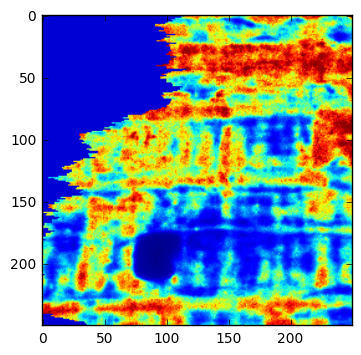

In [112]:
plt.imshow(cubes_set[614]["cube"])